<h1 align="center">Improving ID3. Tune hyperparameters, pruning.</h1>

In [47]:
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('C:/Users/Alexey/jupyter_notebooks/datasets/titanic.csv', usecols=['Pclass', 'Fare', 'Age', 'Sex', 'SibSp', 'Survived']).dropna()

y = df.Survived
X = df.drop(['Survived'], axis=1)
X['Sex'] = X['Sex'].apply(lambda sex: 1 if sex == 'male' else 0)

Splitting dataset to train and test

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

## 1. Common ID3

First we will fit a normal decision tree without any fine tuning and check the results

In [50]:
common_tree = tree.DecisionTreeClassifier(random_state=0)
common_tree.fit(X_train, y_train)
train_common_pred = common_tree.predict(X_train)
val_common_pred = common_tree.predict(X_val)

#### Visualizing

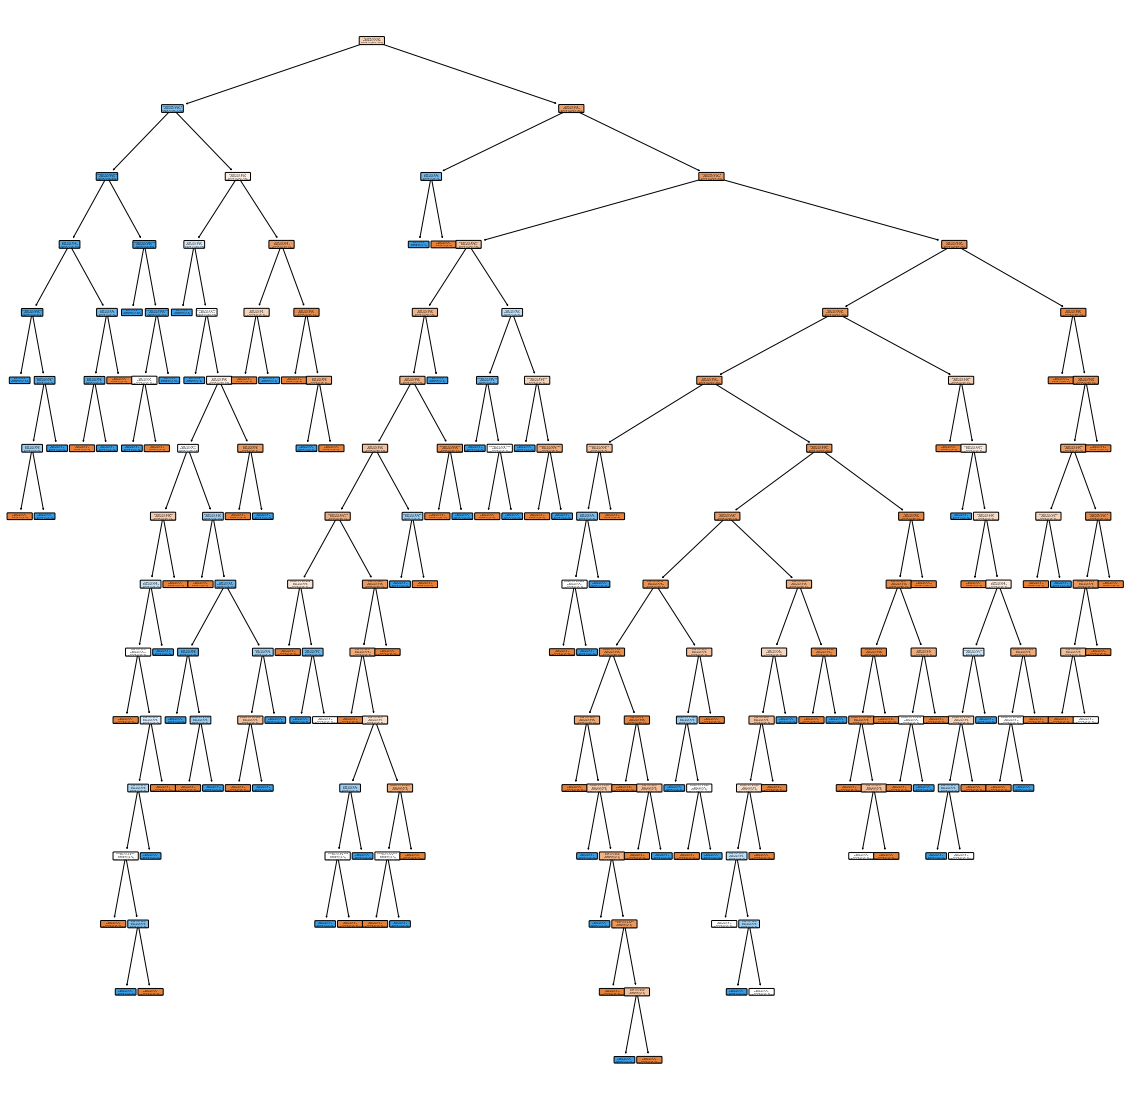

In [51]:
classes = ['Not survived', 'Survived']

plt.figure(figsize=(20, 20))
tree.plot_tree(common_tree,
               feature_names=df.columns,
               class_names=classes,
               filled=True,
               rounded=True,)
plt.show()

In [52]:
# helper function for plot confusion matrix

def plot_confusionmatrix(y_train_pred, y_train, dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred, y_train)
    sns.heatmap(cf, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

#### Result & confusion matrix

Train score 0.985981308411215
Val score 0.7622377622377622
Train Confusion matrix


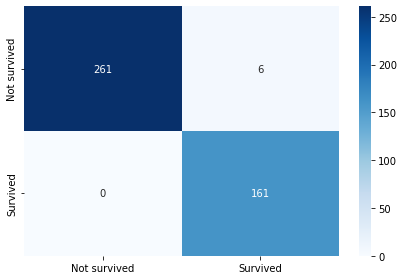

Validate Confusion matrix


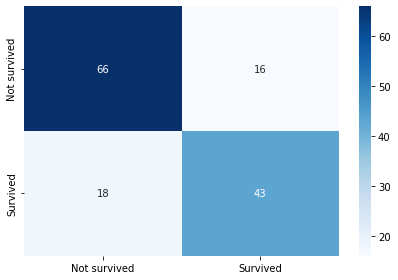

In [53]:
print(f'Train score {accuracy_score(train_common_pred, y_train)}')
print(f'Val score {accuracy_score(val_common_pred, y_val)}')
plot_confusionmatrix(train_common_pred, y_train, dom='Train')
plot_confusionmatrix(val_common_pred, y_val, dom='Validate')

We can see that in our train data we have 98% accuracy (98 % precison and recall). But in validate data model is not well generalizing. We have just 76% accuracy. Over model is clearly overfitting. We will avoid overfitting through pruning. We will do cost complexity prunning

## 2. Tuning hyperparameters

Pre pruning is nothing but stoping the growth of decision tree on an early stage. For that we can limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc.

An effective way to do is that we can grid search those parameters and choose the optimum values that gives better performace on test data. 

As of now we will control these parameters
* max_depth: maximum depth of decision tree
* min_sample_split: The minimum number of samples required to split an internal node:
* min_samples_leaf: The minimum number of samples required to be at a leaf node.

In [54]:
params = {'max_depth': range(2, 30),
         'min_samples_split': range(2, 6),
         'min_samples_leaf': range(1, 7),
         'criterion': ['entropy', 'gini'],
         'max_features': ['auto', None, 'log2']}

tune_tree = tree.DecisionTreeClassifier(random_state=0)
gvc = GridSearchCV(estimator=tune_tree, param_grid=params)
gvc.fit(X_train, y_train)

tune_tree = gvc.best_estimator_
tune_tree.fit(X_train, y_train)
gvc.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

#### Visualizing

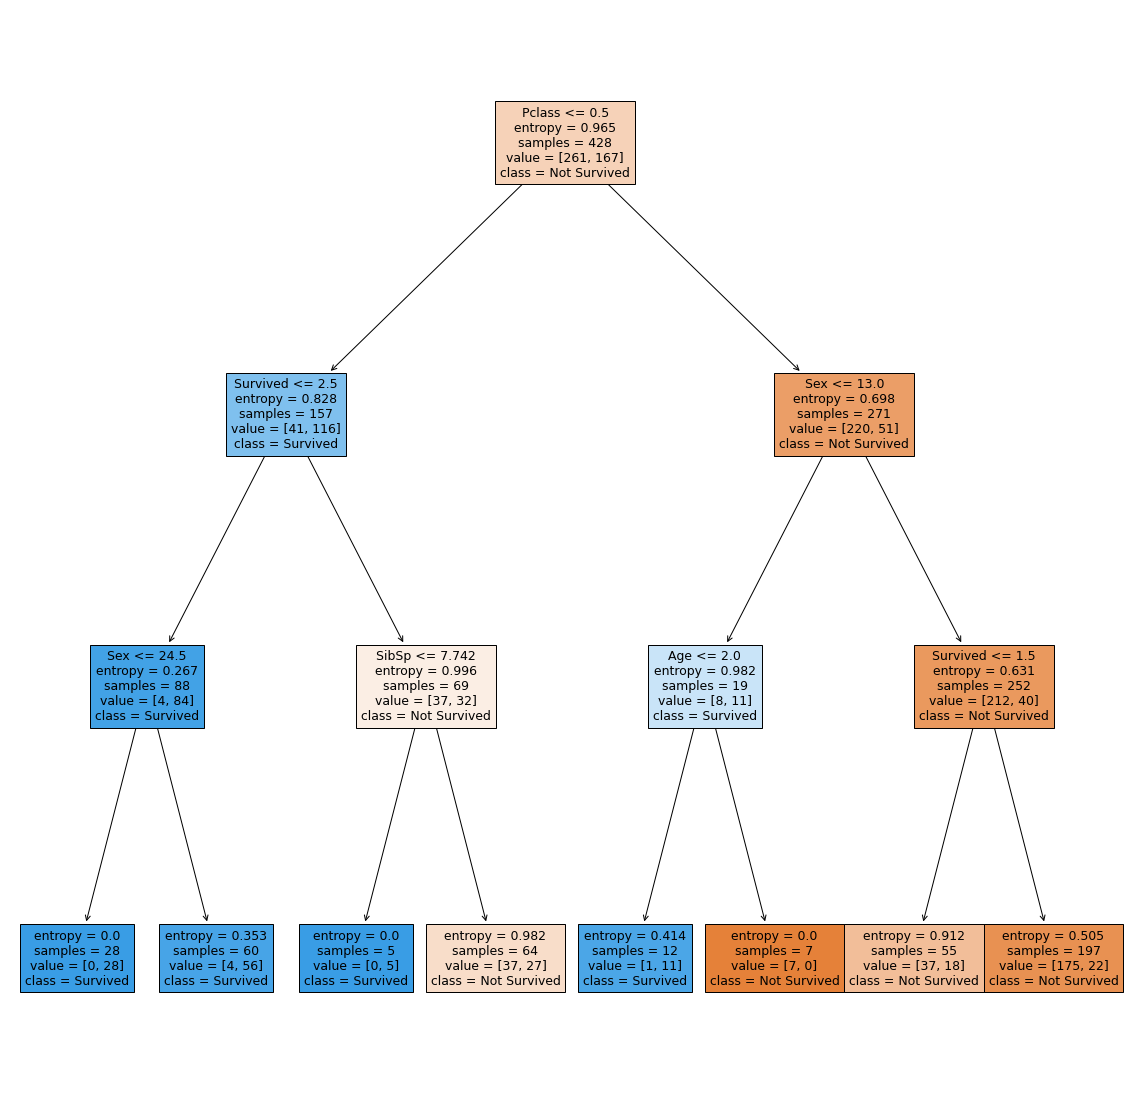

In [55]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not Survived','Survived']
tree.plot_tree(tune_tree, feature_names=features, class_names=classes, filled=True)
plt.show()

#### Result & confusion matrix

Train score 0.8317757009345794
Val score 0.8461538461538461
Train Confusion matrix


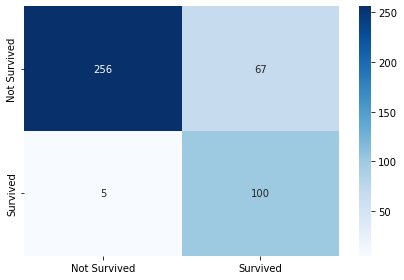

Validation Confusion matrix


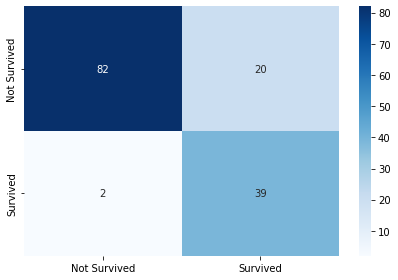

In [56]:
train_tune_pred = tune_tree.predict(X_train)
val_tune_pred = tune_tree.predict(X_val)

print(f'Train score {accuracy_score(train_tune_pred, y_train)}')
print(f'Val score {accuracy_score(val_tune_pred, y_val)}')
plot_confusionmatrix(train_tune_pred, y_train, dom='Train')
plot_confusionmatrix(val_tune_pred, y_val, dom='Validation')

We can see that tree is pruned and there is improvement in validate accuracy. But still there is still scope of improvement.

## 3. Pruning

There are several post pruning techniques. Cost complexity pruning is one of the important among them.

#### Cost Complexity Pruning theory


Decision trees can easily overfit. One way to avoid it is to limit the growth of trees by setting constrains. We can limit parameters like *max_depth* , *min_samples* etc. But a most effective way is to use post pruning methods like cost complexity pruning. This helps to improve test accuracy and get a better model.

Cost complexity pruning is all about finding the right parameter for **alpha**. We will get the alpha values for this tree and will check the accuracy with the pruned trees.

#### Prunning

In [57]:
# we will prunning common ID3 (without any fine tuning)

common_tree = tree.DecisionTreeClassifier(random_state=0)
path = common_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

We will remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node.

In [59]:
# for each alpha we'll append our model to a list

models = list()
for alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    models.append(clf)

models = models[:-1]
ccp_alphas = ccp_alphas[:-1]

##### Plots

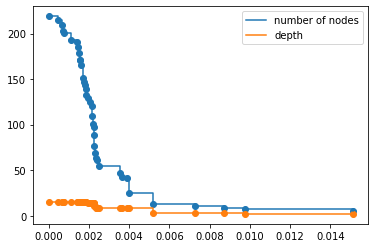

In [60]:
node_counts = [clf.tree_.node_count for clf in models]
depth = [clf.tree_.max_depth for clf in models]
plt.scatter(ccp_alphas, node_counts)
plt.scatter(ccp_alphas, depth)
plt.plot(ccp_alphas, node_counts, label='number of nodes', drawstyle="steps-post")
plt.plot(ccp_alphas, depth, label='depth', drawstyle="steps-post")
plt.legend()
plt.show()

Observation: As alpha increases no of nodes and depth decreases

In [61]:
train_acc = list()
val_acc = list()

for clf in models:
    train_prun_pred = clf.predict(X_train)
    val_prun_pred = clf.predict(X_val)
    train_acc.append(accuracy_score(train_prun_pred, y_train))
    val_acc.append(accuracy_score(val_prun_pred, y_val))

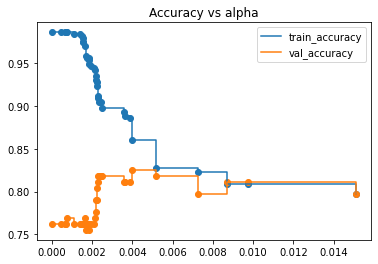

In [62]:
plt.scatter(ccp_alphas, train_acc)
plt.scatter(ccp_alphas, val_acc)
plt.plot(ccp_alphas, train_acc, label='train_accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, val_acc, label='val_accuracy', drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [63]:
# find best alpha
ccp_alphas[val_acc.index(max(val_acc))]

0.0040032543391188245

#### Result & confusion matrix

Train score 0.8598130841121495
Val score 0.8251748251748252
Train Confusion matrix


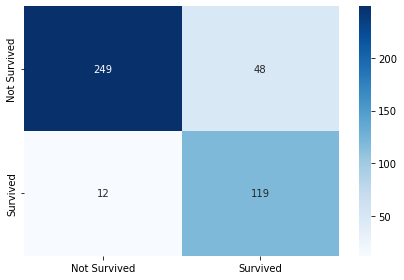

Val Confusion matrix


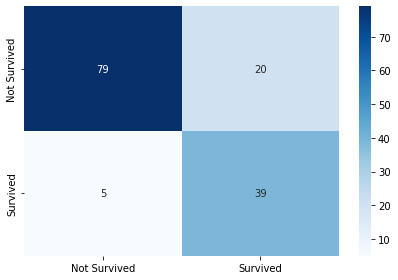

In [64]:
prun_tree = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=0.0040032543391188245)
prun_tree.fit(X_train, y_train)
train_prun_pred = prun_tree.predict(X_train)
val_prun_pred = prun_tree.predict(X_val)

print(f'Train score {accuracy_score(train_prun_pred, y_train)}')
print(f'Val score {accuracy_score(val_prun_pred, y_val)}')
plot_confusionmatrix(train_prun_pred, y_train, dom='Train')
plot_confusionmatrix(val_prun_pred, y_val, dom='Val')

We can see that now our model is not overfiting and performance on validate  data have improved

#### Visualizing

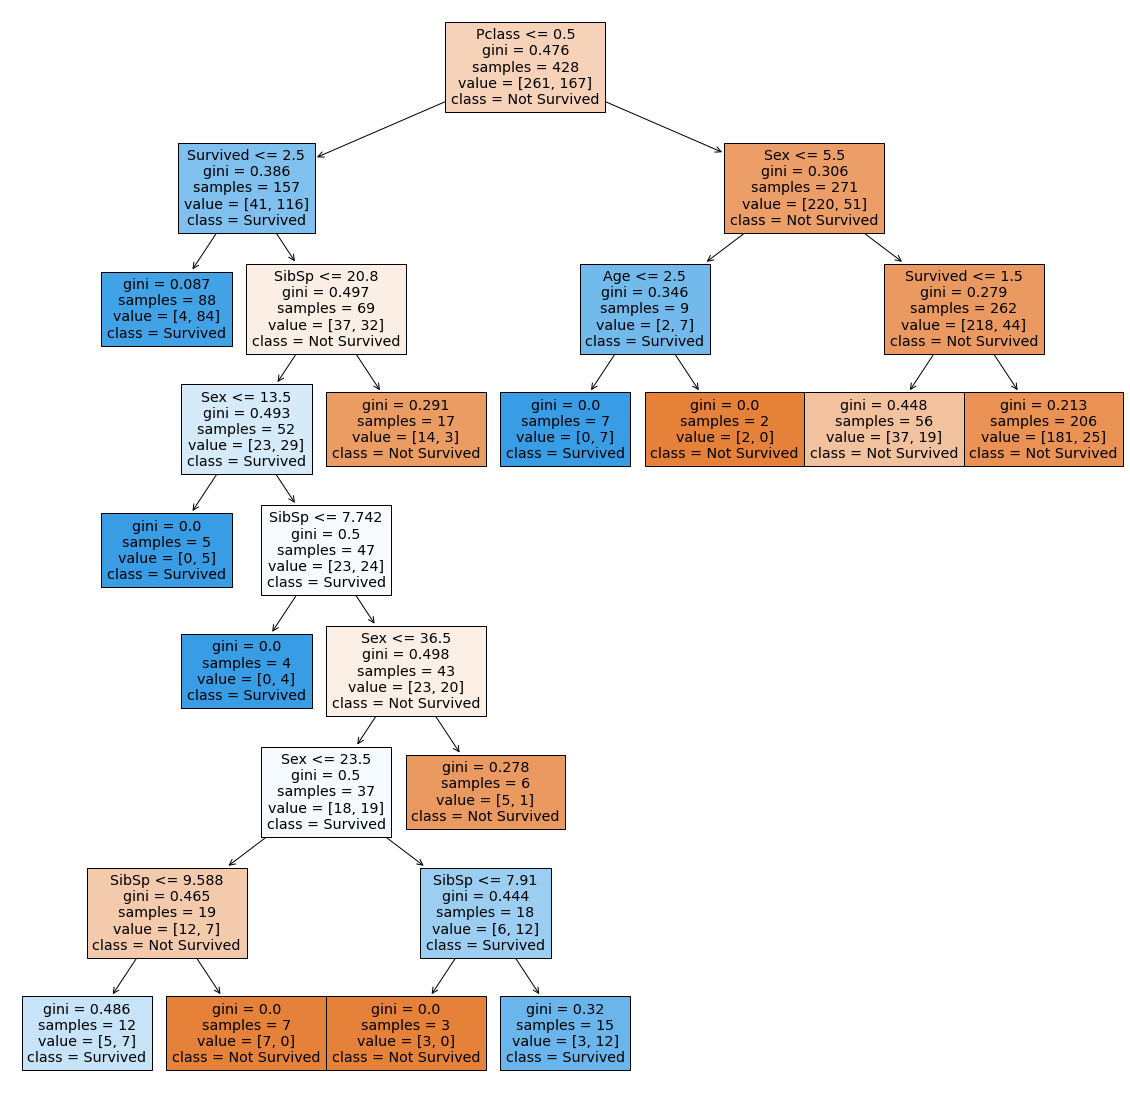

In [65]:
plt.figure(figsize=(20,20))
features = df.columns
classes = ['Not Survived','Survived']
tree.plot_tree(prun_tree, feature_names=features,class_names=classes,filled=True)
plt.show()

We can see that the size of decision tree significantly got reduced. Also postpruning is much efficient than prepruning.

Note: In this kernel we have used accuracy as metric.But the target label is imbalenced. So it is better to use metrics like auc, f1 score etc

## Comparing results on the test data

Finally we have a common id3, tunned tree and prunned tree, lets compare these models on the test data

In [66]:
common_tree = tree.DecisionTreeClassifier(random_state=0)
common_tree.fit(X_train, y_train)

print(f'Common tree: {accuracy_score(common_tree.predict(X_val), y_val)}')
print(f'Tunned tree: {accuracy_score(tune_tree.predict(X_val), y_val)}')
print(f'Prunned tree: {accuracy_score(prun_tree.predict(X_val), y_val)}')

Common tree: 0.7622377622377622
Tunned tree: 0.8461538461538461
Prunned tree: 0.8251748251748252


In [67]:
print(f'Common tree: {accuracy_score(common_tree.predict(X_test), y_test)}')
print(f'Tunned tree: {accuracy_score(tune_tree.predict(X_test), y_test)}')
print(f'Prunned tree: {accuracy_score(prun_tree.predict(X_test), y_test)}')

Common tree: 0.7972027972027972
Tunned tree: 0.7902097902097902
Prunned tree: 0.8111888111888111


Finally we've got a result, our prunned tree have better accuracy on test sample.